In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy

# setting plot fonts
fontdict = {'family': 'Times New Roman', 'size': 20}

We assume a two-state model:
$$
P + T \to 2 T \\
2 T \to P + T
$$
The model is a reverse 2-state kinetic model, where $P$ stands for primer pair concentration, $T$ for synthesized template concentration. The forward rate constant is $k_1$ and the reverse kinetic rate constant is $k_2$. To solve this discrete-step kinetic equation, we can turn it instead into a continuous-time kinetic equation by treating the step index $n$ as a continuous value. The corresponding differential equation is then:
$$
\frac{dT}{dn} = PTk_1 - k_2 T^2
$$
The solution of this continuous-step evolution kinetic equation for template concentration $T$ is therefore
$$
T_n = \frac{k_1 P_0}{2(k_1+k_2)} \tanh\left(\frac{k_1 P_0 (n-C)}{2}\right) + 1
$$
which is a hyperbolic function that satisfied the tendency of the real-time qPCR fluorescence data

In [2]:
def qPCR_kinetic(n, F0, DF, k1, k2, p0, C):
    return F0+DF*(k1*p0)/(2*(k1+k2))*np.tanh((k1*p0*(n-C))/(2))+1;

Copy number calculation is done by using the average length of the standard sample, and the average molecular weight of a base-pair is chosen to be 618 $g/mol$.

In [3]:
def calculate_copy_number(length, concentration, volume):
    """
    concentration: ng/ul
    volume: ul
    length: number of base pairs
    """
    mass = concentration * volume * 1e-9 # g
    mass_per_molecule = length * 618 / (6.02214199 * 1e23) # g/molecule
    return mass / mass_per_molecule

In [4]:
def calculate_ct(names, curves, cycles, init_ct_estimate=5, ct_increment=3, save=False):
    """
    calculate ct value based on a 2-state kinetic model
    curves: input list of np.array, each np.array is a SYBR-ROX value for each step
    init_ct_estimate: starting ct of the first curve
    ct_increment: estimated ct increment of each dilution 
    save: if true, save the fitted figure
    """
    fontdict = {'family': 'Times New Roman', 'size': 20}
    ct = []
    k1s = []
    k2s = []
    k1 = 1
    k2 = 1e-6
    p0 = 1
    plt.figure(figsize=(10, 8))
    for i, name in enumerate(names):
        signal = curves[i]
        f0 = signal[0]
        df = signal[-1]-f0
        popt, pcov = scipy.optimize.curve_fit(qPCR_kinetic, np.arange(cycles), signal, \
                                    [f0, df, k1, k2, p0, init_ct_estimate], \
                                   method='lm')
        init_ct_estimate += 3
        ct.append(popt[5])
        k1s.append(popt[2])
        k2s.append(popt[3])
        plt.plot(np.arange(cycles), signal, 'o', label=f'{name}')
        plt.plot(np.arange(cycles), qPCR_kinetic(np.arange(cycles), *popt), '-')

    plt.legend()
    plt.xlabel(r"Cycle number", fontdict=fontdict)
    plt.ylabel(r'Fluorescence signal (a. u.)', fontdict=fontdict)
    if save: 
        plt.savefig('kinetic_fit.tif', dpi=300)
    return ct, k1s, k2s, p0

In [5]:
def calculate_standard_curve(copy_number, ct, save=False):
    fontdict = {'family': 'Times New Roman', 'size': 20}
    plt.figure(figsize=(10, 8))
    sns.regplot(x=np.log(copy_number), y=np.array(ct))
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x = np.log(copy_number), y = ct)
    plt.xlabel(r'Logarithm of copy number', fontdict=fontdict)
    plt.ylabel(r'Threshold $C_T$', fontdict=fontdict)
    if save:
        plt.savefig('standard_fit.tif', dpi=300)
    return slope, intercept, rvalue, pvalue, stderr

In [6]:
def cross_point(y, th):
    """
    function for calculating the cross point of a predefined threshold with the fluorescence signal curves
    """
    x = 0
    dy = th - y
    for i in range(len(y) - 1):
        if np.dot(dy[i], dy[i+1]) == 0:
            if dy[i] == 0:
                x = i
            if dy[i+1] == 0:
                x = i + 1
        elif np.dot(dy[i], dy[i+1]) < 0:
            x = i + dy[i] / (y[i+1] - y[i])
        else:
            pass
    return x

In [7]:
def calculate_ct_by_threshold(names, curves, cycles, threshold):
    ct = []
    for i, name in enumerate(names):
        ct.append(cross_point(curves[i], threshold))
    return ct

In [8]:
filename = './data.csv'
raw_data = pd.read_csv(filename, header=7)
labels = 'ABCDEFGH'
nums = '13579'
sybr = []
for i in nums:
    exp = []
    for j in labels:
        sample = raw_data["SYBR"][raw_data["Well"] == j+i].values.astype(float)
        exp.append(sample)
    sybr.append(exp)

rox = []
for i in nums:
    exp = []
    for j in labels:
        sample = raw_data["ROX"][raw_data["Well"] == j+i].values.astype(float)
        exp.append(sample)
    rox.append(exp)
data = []
for i in range(5):
    e = []
    for j in range(8):
        s = sybr[i][j] - rox[i][j]
        e.append(s)
    data.append(e)

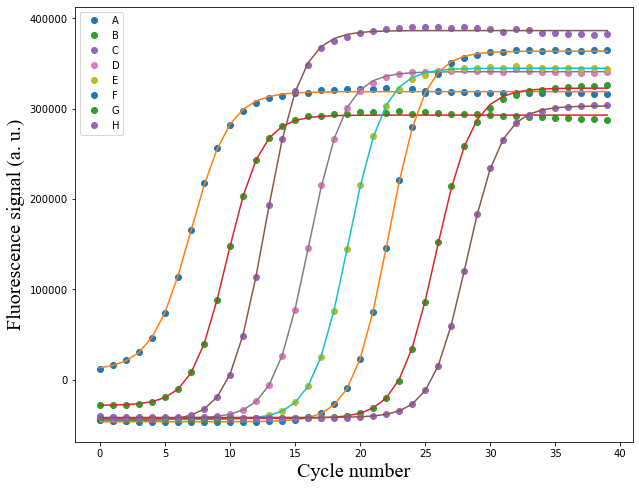

In [9]:
ct = []
k1s = []
k2s = []
k1 = 1
k2 = 1e-6
p0 = 1
C = 5
plt.figure(figsize=(10, 8))
labels = 'ABCDEFGH'
for i, name in enumerate(labels):
    signal = data[0][i][3*np.arange(40)+2]
    f0 = signal[0]
    df = signal[-1]-f0
    popt, pcov = scipy.optimize.curve_fit(qPCR_kinetic, np.arange(40), signal, \
                                [f0, df, k1, k2, p0, C], \
                               method='lm')
    C += 3
    ct.append(popt[5])
    k1s.append(popt[2])
    k2s.append(popt[3])
    plt.plot(np.arange(40), signal, 'o', label=f'{name}')
    plt.plot(np.arange(40), qPCR_kinetic(np.arange(40), *popt), '-')

plt.legend()
plt.xlabel(r"Cycle number", fontdict=fontdict)
plt.ylabel(r'Fluorescence signal (a. u.)', fontdict=fontdict)
plt.savefig('kinetic_fit_to_raw_fluorescence_signal.tif', dpi=300)

The fitting function is taken to be 
$$
F(n) = F_0 + \Delta F \cdot \tanh(k(n-C))
$$

$\Delta F$ reflecting the average SYBR attached to the syntheszed DNA strains. $F_0$ is the initial fluorescence for the present of sample DNA molecules. $k$ is determined by the polymorase determined synthetic rates. The inhibition effects as characteristic by the amount of present synthetic DNA molecules and the reduced amount of primers is reflected in the plateu for large $n$. $C$ is the value which we chosen to be the new defined threshold for standard curve drawing and absolute quantification of sample copy numbers. 

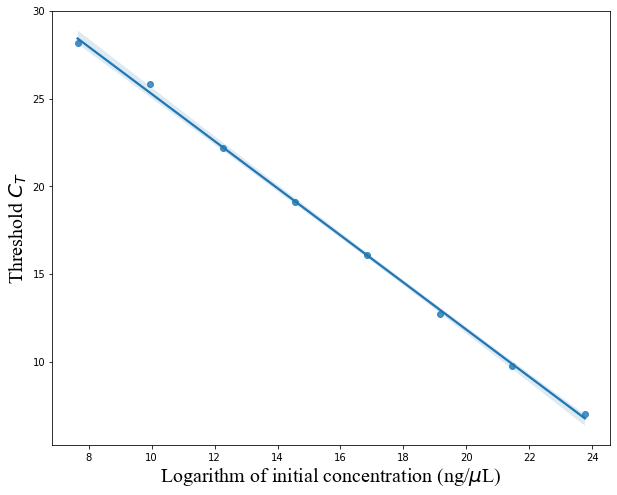

In [10]:
n0 = calculate_copy_number(7861, 84.6, 2) / 10 ** np.arange(8)
plt.figure(figsize=(10, 8))
sns.regplot(x=np.log(n0), y=np.array(ct))
plt.xlabel(r'Logarithm of initial concentration ' + r'(ng/$\mu$L)', fontdict=fontdict)
plt.ylabel(r'Threshold $C_T$', fontdict=fontdict)
plt.savefig('kinetic_fit_std_curve.tif', dpi=300)

The efficiency change can be found by calculating the differential of the continuous-step kinetic equation, 
$$
T'(n) = -\frac{k_1^2P_0^2}{4(k_1+k_2)}\left\{\tanh^2\left[\frac{k_1P_0(n-C)}{2}\right]-1\right\}
$$
Since $\tanh^2(\cdot)$ is a symmetric function, the maximum point will be corresponding to $C$. Thus we have illustrated the physical meaning of $C$, which is the maximum efficiency point obtained from the real-time qPCR fluorescence signal. 
We can solve $C$ for the initial concentration of template $T_0$ as 
$$
C = \frac{1}{P_0k_1} \ln \left[\frac{P_0k_1}{T_0(k_1 + k_2} - 1\right]
$$
While at equilibrium, i.e. at the end of the amplification kinetic curve, if we let $T_{eq}$ denote the final template concentration at the plateau phase, we have 
$$
T_{eq} = \frac{P_0k_1}{k_1 + k_2}
$$
Therefore, we obtain the relationship of $C$ and the initial concentration (or copy number) of the template as 
$$
C = \frac{1}{T_{eq}(k_1 + k_2)} \ln \left(\frac{T_{eq}}{T_0} - 1\right)
$$
Since the exponential amplification, we would expect $T_{eq} \gg T_0$, which means we can write the above equation as 
$$
C = -\frac{1}{T_{eq}(k_1 + k_2)} \ln(T_0) + \frac{1}{T_{eq}(k_1 + k_2)} \ln (T_{eq})
$$
Thus we have arrived at a linear relationship between the maximum efficiency and the initial concentration of the template under investigation. 
The negative slope is
$$
\frac{1}{T_{eq}(k_1 + k_2)} 
$$
And the intercept is 
$$
\frac{1}{T_{eq} (k_1 + k_2) \ln (T_{eq})} 
$$
which are all functions of the sum of kinetic rate constants and the final concentration of the template. 

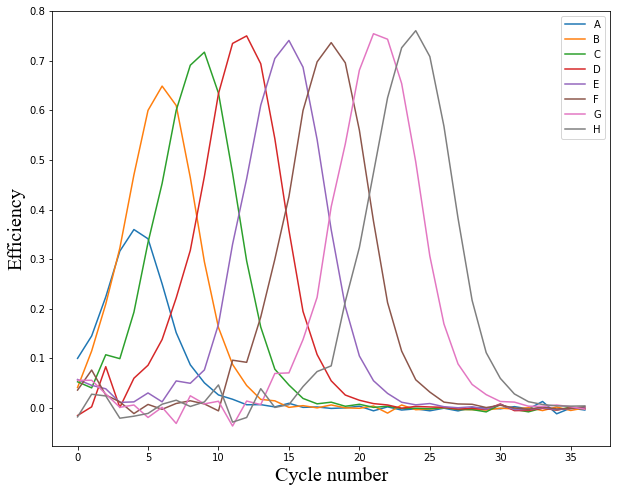

In [11]:
efficiency = []
for i in range(8):
    diff1 = data[0][i][3*np.arange(0, 40)+2] - data[0][i][3*np.arange(0, 40)+3]
    diff2 = data[0][i][3*np.arange(0, 40)+5] - data[0][i][3*np.arange(0, 40)+6]
    efficiency.append(diff2/diff1)

plt.figure(figsize=(10, 8))
for i, name in enumerate(labels):
    plt.plot(efficiency[i][1:-2]-1, label=name)
    
plt.xlabel(r'Cycle number', fontdict=fontdict)
plt.ylabel(r'Efficiency', fontdict=fontdict)
plt.legend()
plt.savefig('fluorescence_signal_step_difference.tif', dpi=300)

In [12]:
def gaussian(xi, *param):
    return param[0]*np.exp(-np.power(xi - param[1], 2.) / (2 * np.power(param[2], 2.)))

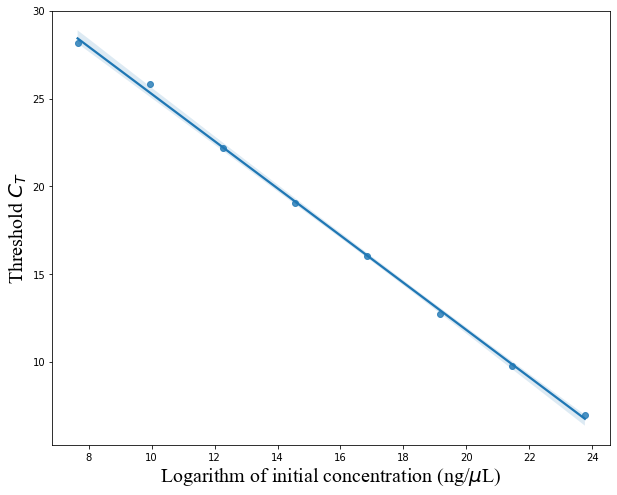

In [13]:
eff_ct = []
for i in efficiency:
    fit_prop, _ = scipy.optimize.curve_fit(gaussian, np.arange(i.size), i, p0=[0, 20, 10])
    eff_ct.append(fit_prop[1])
    
plt.figure(figsize=(10,8))
sns.regplot(x=np.log(n0), y=np.array(ct))
plt.xlabel(r'Logarithm of initial concentration ' + r'(ng/$\mu$L)', fontdict=fontdict)
plt.ylabel(r'Threshold $C_T$', fontdict=fontdict)
plt.savefig('maximum_efficiency_std_curve.tif', dpi=300)

These two standard curve methods are the same. Both of them are insensitive to the fluctuations of the baseline, and the efficiency change along the amplification progress. For the ''fit-point'' or ''threahold-based'' methods, inherent fluctuations of the recorded fluorescence signals are thought to have impacts on the analysis results.  

Besides, we see the plateau contains much information about the reaction kinetics, particularly about the position of the maximum efficiency. This is quite reasonable, since the maximum efficiency will comes out for when the template had been accumulated enough and also there is enough primer resources available in the tube. 